In [1]:
%pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Conv1D, MaxPooling1D, Flatten, Dropout
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
wine_quality = fetch_ucirepo(name="Wine Quality")
dataset = wine_quality.data.original

In [3]:
keras.utils.set_random_seed(49)

In [4]:
display(dataset.head())

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality color  
0      9.4        5   red  
1      9.8        5   red  
2      9.8        5   red  
3      9.8        6   red  
4      9.4        5   red

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [6]:
print("Number of Duplicates in dataset:",dataset.duplicated().sum())

Number of Duplicates in dataset: 1177


In [7]:
print("Duplicated targets:\n", dataset[dataset.duplicated()]["quality"].value_counts())

Duplicated targets:
 quality
6    513
5    386
7    223
8     45
4     10
Name: count, dtype: int64


In [8]:
dataset = dataset.drop_duplicates()
dataset

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
5               7.4              0.66         0.00             1.8      0.075   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
5                    13.0                  40.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
6492                 24.0                  92.0  0.99114  3.27       0.50   
6493                 57.0                 168.0  0.99490  3.15       0.46   
6494                 30.0                 111.0  0.99254  2.99       0.46   
6495                 20.0                 110.0  0.98869  3.34       0.38   
6496                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality  color  
0         9.4        5    red  
1         9.8        5    red  
2         9.8        5    red  
3         9.8        6    red  
5         9.4        5    red  
...       ...      ...    ...  
6492     11.2        6  white  
6493      9.6        5  white  
6494      9.4        6  white  
6495     12.8        7  white  
6496     11.8        6  white  

[5320 rows x 13 columns]

In [9]:
minModalities = 7 ## To match dataset desciprtion on UCI website, numerical variables with less than 7 modalities are considered as nominal

def getCategFeat(df, n, target):
    """
    get dataframe's categorical features
    Inputs :
        df     -- dataframe
        n      -- min modalities for numerical features
        target -- target column name
    """
    return [c for c in df.columns if (df[c].dtype == 'O' or df[c].nunique()<n) and c!=target]


categorical_features = getCategFeat(dataset,minModalities,'quality')

print("Categorical Features : ",categorical_features)
numerical_features = [c for c in dataset.columns if c not in categorical_features and c!="quality"]
print("Numerical Features : ", numerical_features)

output_variable = ['quality']

Categorical Features :  ['color']
Numerical Features :  ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']


Text(0.5, 1.0, 'Distribution of quality for white wine')

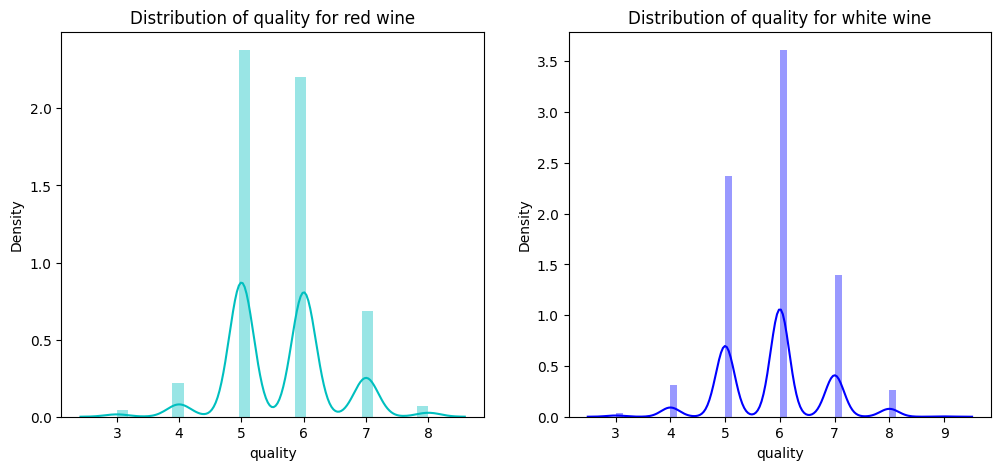

In [10]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(dataset[(dataset.color == 'red')]["quality"],color='c',ax=ax)
ax.set_title('Distribution of quality for red wine')

ax=f.add_subplot(122)
sns.distplot(dataset[(dataset.color == 'white')]['quality'],color='b',ax=ax)
ax.set_title('Distribution of quality for white wine')

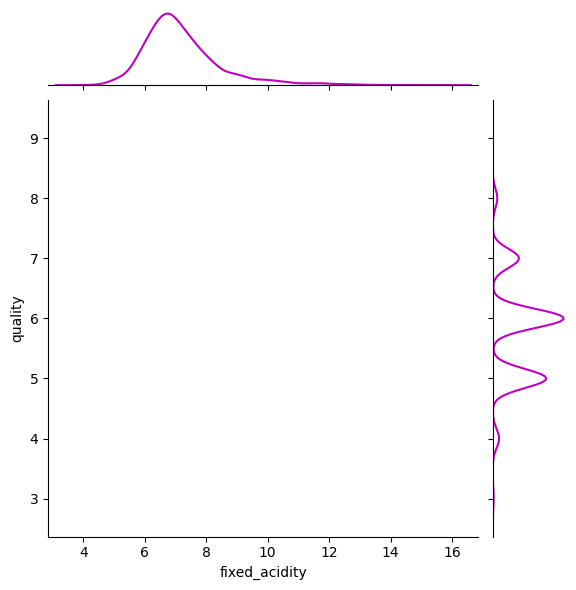

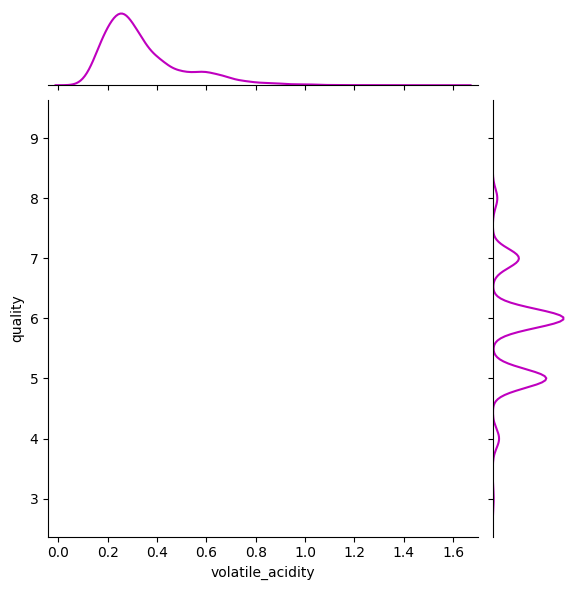

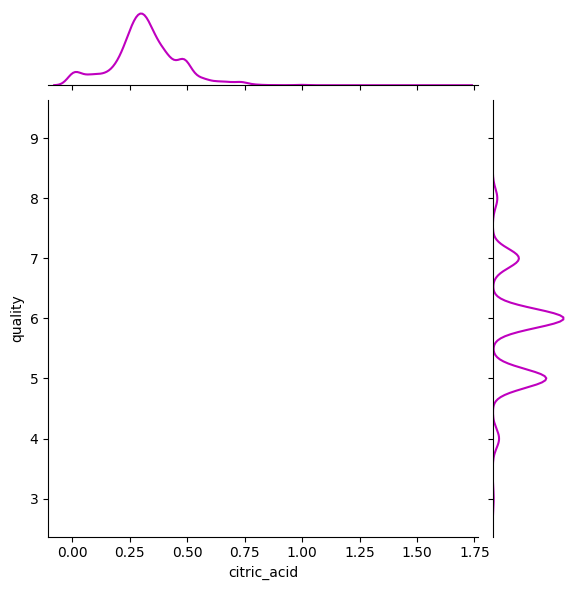

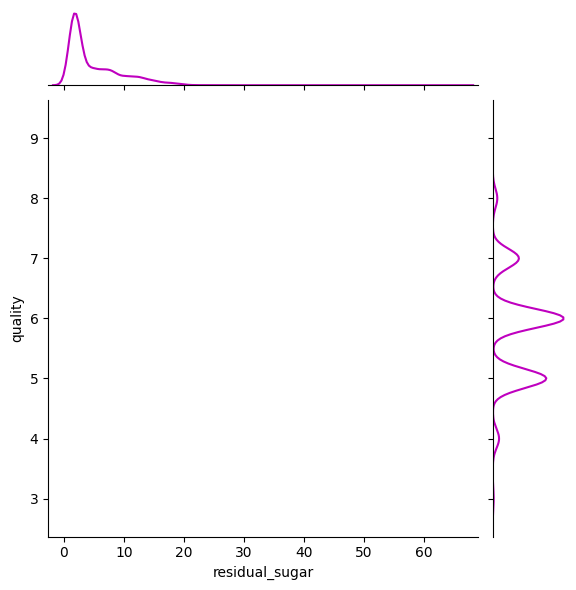

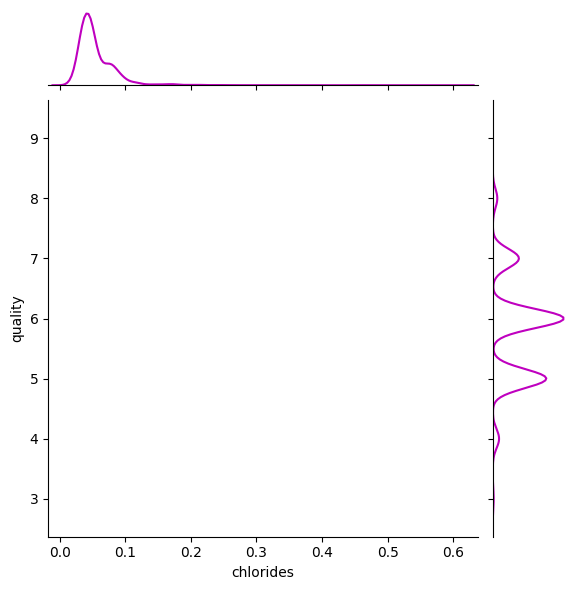

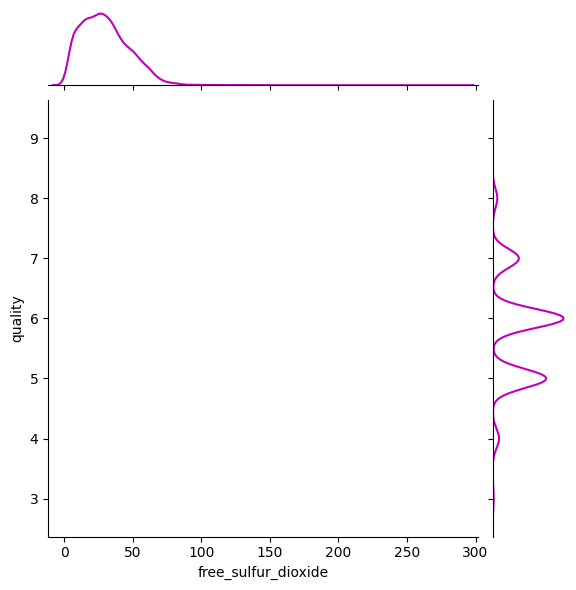

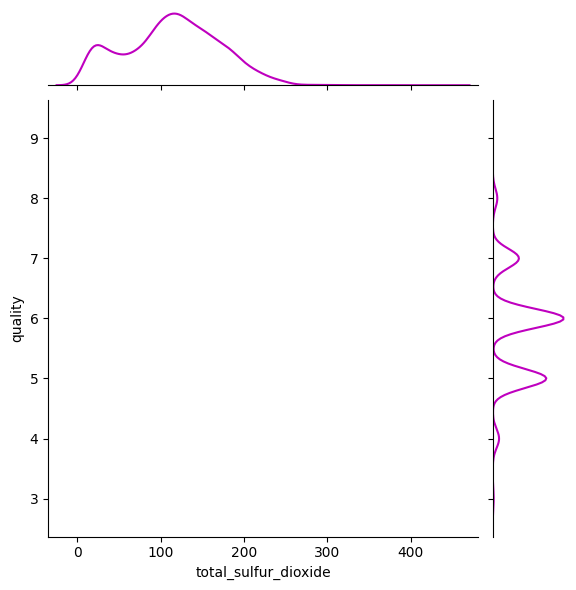

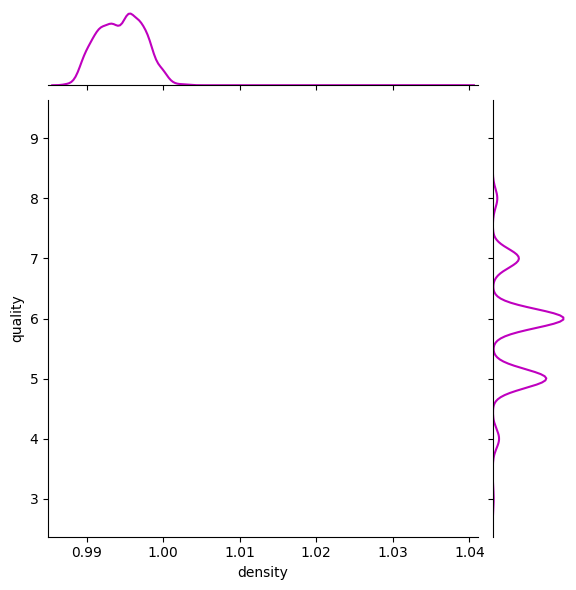

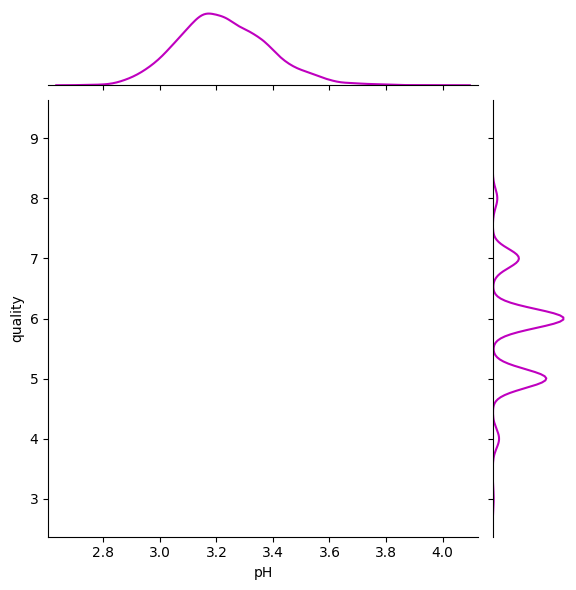

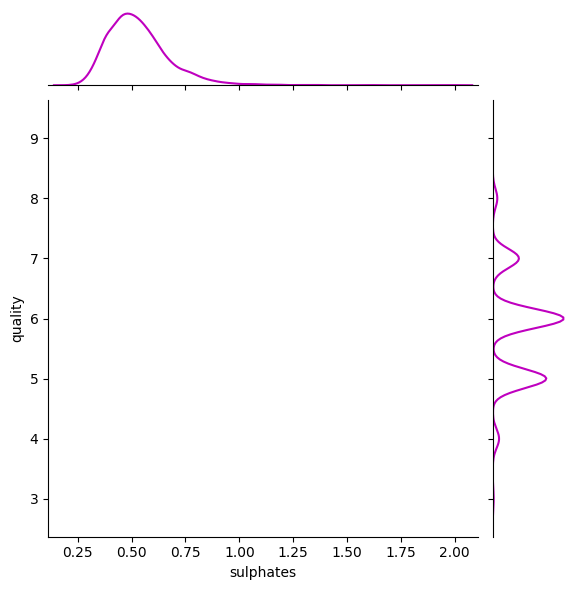

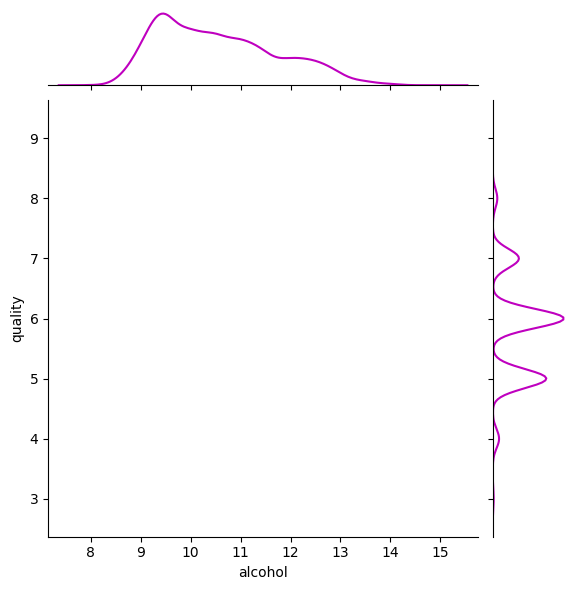

In [11]:
for num_var in numerical_features:
    g = sns.jointplot(x=num_var, y="quality", data = dataset, kind="kde", color="m")
    g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
    g.ax_joint.collections[0].set_alpha(0)
    g.set_axis_labels(num_var, "quality")
    ax.set_title('Distribution of wine quality scores against wine features')

<Axes: xlabel='quality'>

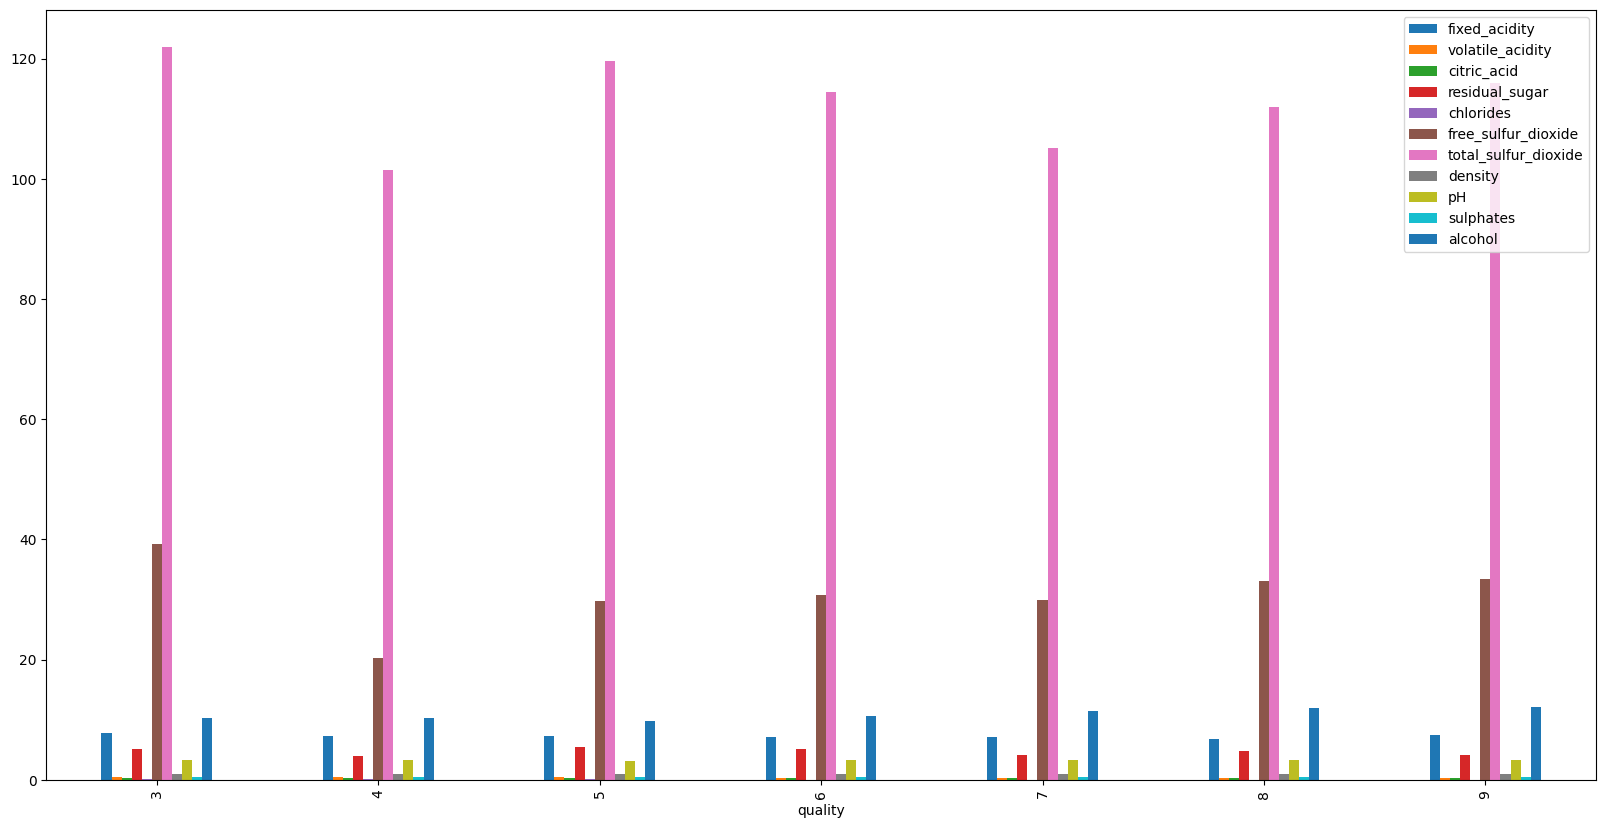

In [12]:
group_quality= dataset.groupby("quality").mean(numeric_only=True)
group_quality.plot(kind="bar",figsize=(20,10))

In [13]:
dataset_correlations = dataset.corr(method='spearman', numeric_only = True)

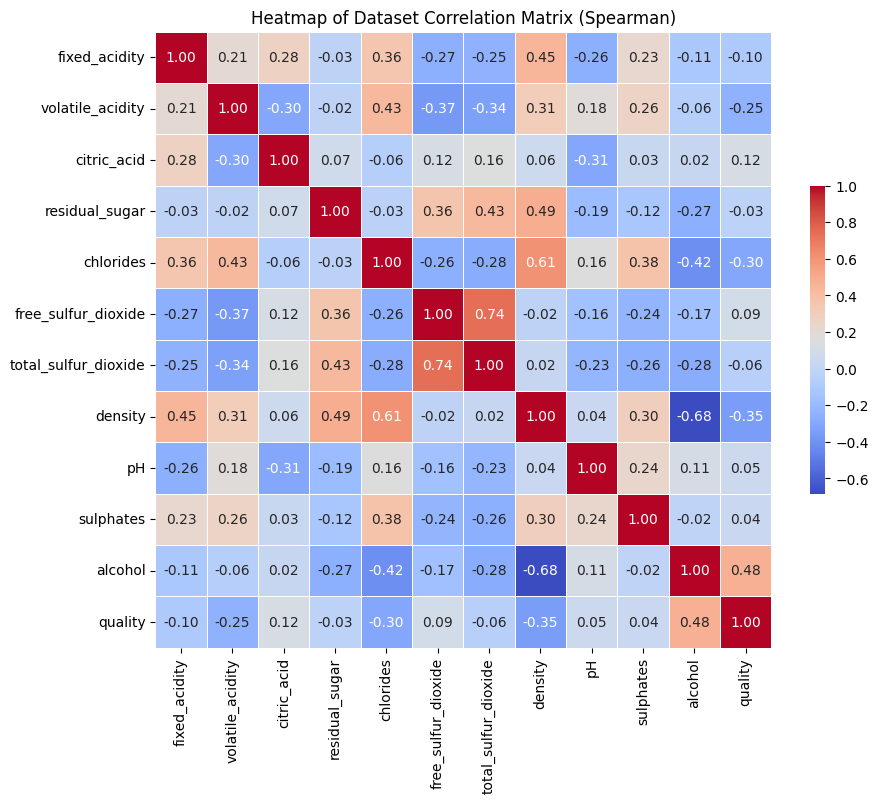

In [14]:
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(dataset_correlations, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Heatmap of Dataset Correlation Matrix (Spearman)')
plt.show()

In [15]:
dataset['color_binary'] = np.where(dataset['color'] =='red', 1, 0)
dataset.drop(columns=['color'], inplace=True)
dataset.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
5            7.4              0.66         0.00             1.8      0.075   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
5                 13.0                  40.0   0.9978  3.51       0.56   

   alcohol  quality  color_binary  
0      9.4        5             1  
1      9.8        5             1  
2      9.8        5             1  
3      9.8        6             1  
5      9.4        5             1

In [16]:
continuous_data = dataset[numerical_features]
std_scalar = StandardScaler().fit(continuous_data)
std_continuous_data = std_scalar.transform(continuous_data)

categorical_data = dataset['color_binary'].to_numpy().reshape(-1,1)

In [17]:
y = dataset['quality'] # target variable
y_adjusted = y-3 # scores range from 3 to 9 , to ensure 7 classes and use to-categorical, we substract three so now it's 0-6
y = to_categorical(y_adjusted, num_classes=7)
x = np.append(categorical_data, std_continuous_data, axis=1)
print(x.shape)
print(y.shape)

(5320, 12)
(5320, 7)


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

print(x_train.shape)
print(y_train.shape)

(3724, 12)
(3724, 7)


In [19]:
def plot_history(model):
  plt.figure(figsize=(10,5))
  plt.plot(model.history['accuracy'], label = 'Training Accuracy')
  plt.plot(model.history['val_accuracy'], label = 'Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs Epochs ')
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(model.history['loss'], label = 'Training Loss')
  plt.plot(model.history['val_loss'], label = 'Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs Epochs ')
  plt.legend()
  plt.show()

  print(f'The layers of the model:')
  for layer in history.model.layers:
    print(str(layer)[18:])

  print("----------------------------------------------------\n")
  return

In [20]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=7, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=2, validation_data = (x_test, y_test), callbacks=[early_stopping])

Epoch 1/200
117/117 - 2s - 15ms/step - accuracy: 0.1351 - loss: 2.2979 - val_accuracy: 0.1729 - val_loss: 2.1714
Epoch 2/200
117/117 - 0s - 3ms/step - accuracy: 0.2116 - loss: 1.9915 - val_accuracy: 0.2450 - val_loss: 1.9111
Epoch 3/200
117/117 - 0s - 3ms/step - accuracy: 0.2919 - loss: 1.7780 - val_accuracy: 0.3252 - val_loss: 1.7267
Epoch 4/200
117/117 - 1s - 5ms/step - accuracy: 0.3716 - loss: 1.6263 - val_accuracy: 0.3784 - val_loss: 1.5911
Epoch 5/200
117/117 - 0s - 2ms/step - accuracy: 0.4197 - loss: 1.5140 - val_accuracy: 0.4192 - val_loss: 1.4877
Epoch 6/200
117/117 - 0s - 3ms/step - accuracy: 0.4525 - loss: 1.4281 - val_accuracy: 0.4436 - val_loss: 1.4069
Epoch 7/200
117/117 - 0s - 3ms/step - accuracy: 0.4799 - loss: 1.3610 - val_accuracy: 0.4731 - val_loss: 1.3433
Epoch 8/200
117/117 - 0s - 3ms/step - accuracy: 0.5008 - loss: 1.3080 - val_accuracy: 0.4825 - val_loss: 1.2930
Epoch 9/200
117/117 - 0s - 2ms/step - accuracy: 0.5177 - loss: 1.2660 - val_accuracy: 0.4887 - val_loss

In [21]:
plot_history(history)

The layers of the model:
 built=True>
----------------------------------------------------



In [22]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=256, activation="relu"),
    Dense(units=7, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=2, validation_data = (x_test, y_test), callbacks=[early_stopping])

Epoch 1/200
117/117 - 1s - 11ms/step - accuracy: 0.5000 - loss: 1.2937 - val_accuracy: 0.5407 - val_loss: 1.1194
Epoch 2/200
117/117 - 0s - 3ms/step - accuracy: 0.5556 - loss: 1.1028 - val_accuracy: 0.5476 - val_loss: 1.0781
Epoch 3/200
117/117 - 0s - 3ms/step - accuracy: 0.5661 - loss: 1.0721 - val_accuracy: 0.5489 - val_loss: 1.0640
Epoch 4/200
117/117 - 0s - 2ms/step - accuracy: 0.5687 - loss: 1.0553 - val_accuracy: 0.5464 - val_loss: 1.0568
Epoch 5/200
117/117 - 0s - 2ms/step - accuracy: 0.5725 - loss: 1.0434 - val_accuracy: 0.5501 - val_loss: 1.0527
Epoch 6/200
117/117 - 0s - 2ms/step - accuracy: 0.5757 - loss: 1.0339 - val_accuracy: 0.5495 - val_loss: 1.0499
Epoch 7/200
117/117 - 0s - 3ms/step - accuracy: 0.5773 - loss: 1.0260 - val_accuracy: 0.5501 - val_loss: 1.0474
Epoch 8/200
117/117 - 0s - 2ms/step - accuracy: 0.5776 - loss: 1.0198 - val_accuracy: 0.5482 - val_loss: 1.0453
Epoch 9/200
117/117 - 0s - 3ms/step - accuracy: 0.5768 - loss: 1.0144 - val_accuracy: 0.5476 - val_loss

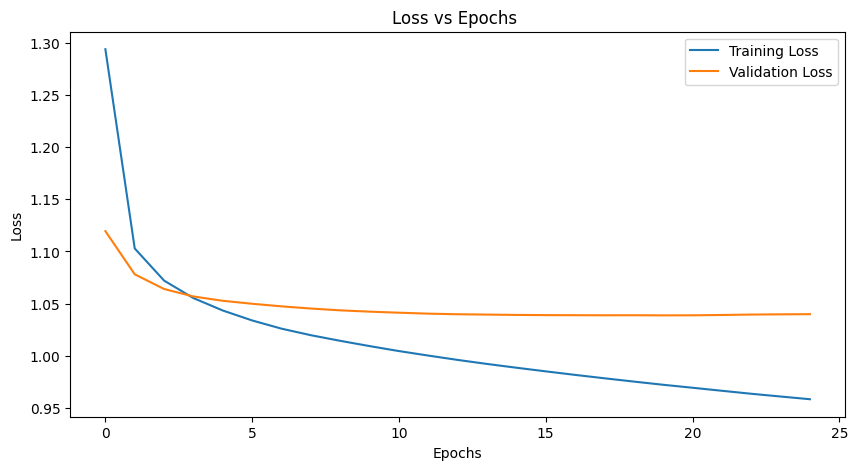

The layers of the model:
1, built=True>
2, built=True>
----------------------------------------------------



In [23]:
plot_history(history)

In [24]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=128, activation="relu"),
    Dense(units=64, activation="relu"),
    Dense(units=7, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=2, validation_data = (x_test, y_test), callbacks=[early_stopping])

Epoch 1/200
117/117 - 2s - 18ms/step - accuracy: 0.4825 - loss: 1.3066 - val_accuracy: 0.5207 - val_loss: 1.1212
Epoch 2/200
117/117 - 0s - 4ms/step - accuracy: 0.5483 - loss: 1.1067 - val_accuracy: 0.5407 - val_loss: 1.0774
Epoch 3/200
117/117 - 0s - 2ms/step - accuracy: 0.5628 - loss: 1.0710 - val_accuracy: 0.5489 - val_loss: 1.0627
Epoch 4/200
117/117 - 0s - 2ms/step - accuracy: 0.5714 - loss: 1.0514 - val_accuracy: 0.5482 - val_loss: 1.0536
Epoch 5/200
117/117 - 0s - 2ms/step - accuracy: 0.5722 - loss: 1.0369 - val_accuracy: 0.5445 - val_loss: 1.0501
Epoch 6/200
117/117 - 0s - 3ms/step - accuracy: 0.5792 - loss: 1.0250 - val_accuracy: 0.5451 - val_loss: 1.0450
Epoch 7/200
117/117 - 0s - 2ms/step - accuracy: 0.5838 - loss: 1.0147 - val_accuracy: 0.5445 - val_loss: 1.0428
Epoch 8/200
117/117 - 0s - 2ms/step - accuracy: 0.5867 - loss: 1.0057 - val_accuracy: 0.5451 - val_loss: 1.0408
Epoch 9/200
117/117 - 0s - 3ms/step - accuracy: 0.5886 - loss: 0.9973 - val_accuracy: 0.5432 - val_loss

In [24]:
plot_history(history)

In [25]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=256, activation="relu"),
    Dense(units = 128, activation = "relu"),
    Dense(units=64, activation="relu"),
    Dense(units=7, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, batch_size=100, verbose=2, validation_data = (x_test, y_test), callbacks=[early_stopping])

Epoch 1/200
38/38 - 2s - 44ms/step - accuracy: 0.4608 - loss: 1.3777 - val_accuracy: 0.5175 - val_loss: 1.1307
Epoch 2/200
38/38 - 0s - 5ms/step - accuracy: 0.5524 - loss: 1.1202 - val_accuracy: 0.5514 - val_loss: 1.0745
Epoch 3/200
38/38 - 0s - 10ms/step - accuracy: 0.5644 - loss: 1.0786 - val_accuracy: 0.5451 - val_loss: 1.0575
Epoch 4/200
38/38 - 0s - 8ms/step - accuracy: 0.5733 - loss: 1.0563 - val_accuracy: 0.5520 - val_loss: 1.0483
Epoch 5/200
38/38 - 0s - 8ms/step - accuracy: 0.5760 - loss: 1.0398 - val_accuracy: 0.5545 - val_loss: 1.0432
Epoch 6/200
38/38 - 1s - 16ms/step - accuracy: 0.5808 - loss: 1.0258 - val_accuracy: 0.5602 - val_loss: 1.0387
Epoch 7/200
38/38 - 1s - 17ms/step - accuracy: 0.5865 - loss: 1.0127 - val_accuracy: 0.5633 - val_loss: 1.0377
Epoch 8/200
38/38 - 1s - 14ms/step - accuracy: 0.5870 - loss: 1.0000 - val_accuracy: 0.5645 - val_loss: 1.0370
Epoch 9/200
38/38 - 0s - 8ms/step - accuracy: 0.5892 - loss: 0.9888 - val_accuracy: 0.5658 - val_loss: 1.0393
Epoch

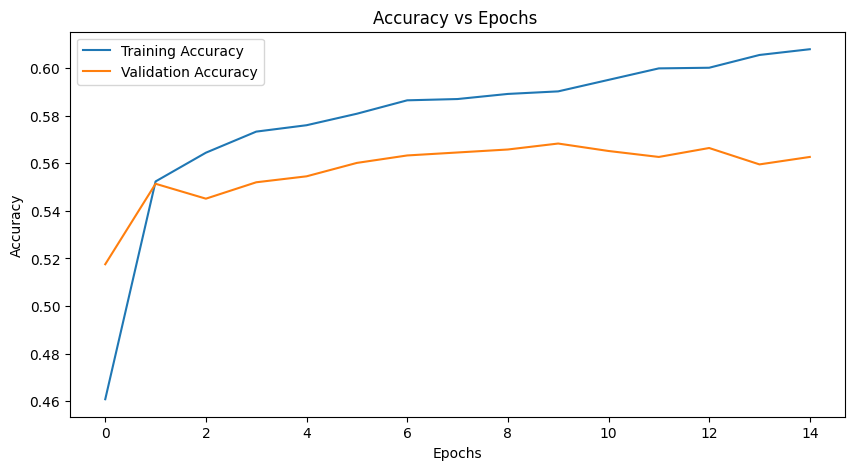

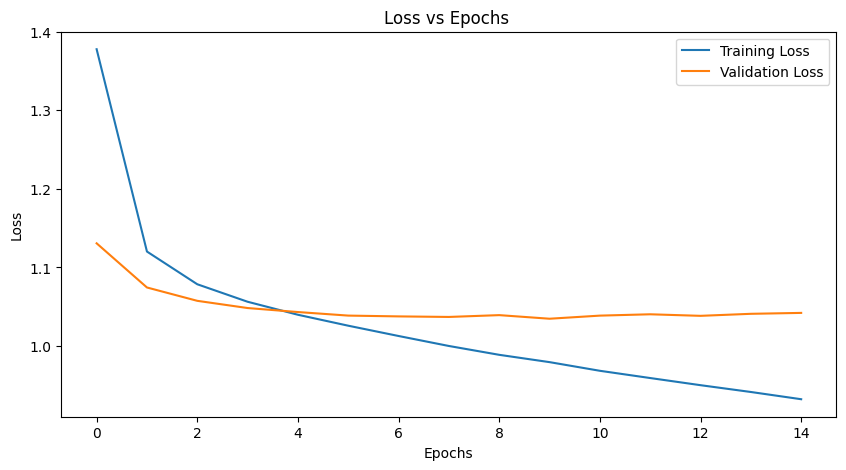

The layers of the model:
6, built=True>
7, built=True>
8, built=True>
9, built=True>
----------------------------------------------------



In [26]:
plot_history(history)

In [27]:
dataset['quality_binary'] = np.where(dataset['quality'] > 5, 1, 0)
dataset.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
5            7.4              0.66         0.00             1.8      0.075   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
5                 13.0                  40.0   0.9978  3.51       0.56   

   alcohol  quality  color_binary  quality_binary  
0      9.4        5             1               0  
1      9.8        5             1               0  
2      9.8        5             1               0  
3      9.8        6             1               1  
5      9.4        5             1               0

In [28]:
continuous_data = dataset[numerical_features]
std_scalar = StandardScaler().fit(continuous_data)
std_continuous_data = std_scalar.transform(continuous_data)

categorical_data = dataset['color_binary'].to_numpy().reshape(-1,1)

In [29]:
y = dataset['quality_binary'] # target variable
x = np.append(categorical_data, std_continuous_data, axis=1)

print(y.shape)
print(x.shape)

(5320,)
(5320, 12)


In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print(x_train.shape, y_train.shape)

(3724, 12) (3724,)
